# 3) 바른자세프로젝트 딥러닝모델 

#학습시킨 모델을 불러온다. 

In [2]:
import tensorflow as tf
import sys
import os
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import numpy as np
import cv2

model = load_model('./model/20-0.8295.hdf5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                524352    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 15,239,300
Trainable params: 524,612
Non-trainable params: 14,714,688
_________________________________________________________________


#새로운 이미지를 넣고 딥러닝 모델을 비교하기 위해서 OPENPOSE를 이용해서 스켈레톤을 만든다. 

In [14]:
# 포인트 찾기
def output_keypoints(frame, proto_file, weights_file, threshold, model_name, BODY_PARTS):
    global points
    # 네트워크 불러오기
    net = cv2.dnn.readNetFromCaffe(proto_file, weights_file)

    # 입력 이미지의 사이즈 정의
    image_height = 368
    image_width = 368

    # 네트워크에 넣기 위한 전처리
    input_blob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (image_width, image_height), (0, 0, 0), swapRB=False, crop=False)

    # mean: 만약 image의 채널이 BGR 순서이고, swapRB가 true이면 R 평균, G평균, B 평균 순서로 값 지정
    # swapRB : 첫 번째 채널과 3번째 채널을 서로 바꿀 것인지를 결정하는 flag.
    # 이 값이 true이면 컬러 입력 영상의 채널 순서를 BGR에서 RGB로 변경
    # crop : 입력 영상(image)의 크기를 변경한 후, crop을 수행할 것인지를 결정하는 flag
    # network입력을 위한 blob으로 변환(blob: 영상 등의 data를 포함할수 있는 다차원 data 표현 방식)
    
    # 전처리된 blob 네트워크에 입력
    net.setInput(input_blob)

    # 결과 받아오기
    out = net.forward()
    out_height = out.shape[2]
    out_width = out.shape[3]

    # 원본 이미지의 높이, 너비를 받아오기
    frame_height, frame_width = frame.shape[:2]

    # 포인트 리스트 초기화
    points = []

    print(f"\n============================== {model_name} Model ==============================")
    for i in range(len(BODY_PARTS)):

        # 신체 부위의 confidence map
        prob_map = out[0, i, :, :]

        # 최소값, 최대값, 최소값 위치, 최대값 위치
        min_val, prob, min_loc, point = cv2.minMaxLoc(prob_map)

        # 원본 이미지에 맞게 포인트 위치 조정
        x = (frame_width * point[0]) / out_width
        x = int(x)
        y = (frame_height * point[1]) / out_height
        y = int(y)

        if prob > threshold:  # [pointed] 
            # cv.circle(그림, 중심, 크기, 색상, 두께(-1이면 꽉채움), 선 유형)
            cv2.circle(frame, (x, y), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            # cv2.putText(그림, 문구, 시작좌표, 폰트종류, 폰트크기, 색상, 사이즈, 선 유형)
            cv2.putText(frame, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1, lineType=cv2.LINE_AA)

            points.append((x, y))
            print(f"[pointed] {BODY_PARTS[i]} ({i}) => prob: {prob:.5f} / x: {x} / y: {y}")

        else:  # [not pointed]
            cv2.circle(frame, (x, y), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frame, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1, lineType=cv2.LINE_AA)

            points.append(None)
            print(f"[not pointed] {BODY_PARTS[i]} ({i}) => prob: {prob:.5f} / x: {x} / y: {y}")

    cv2.imshow("Output_Keypoints", frame)
    cv2.waitKey(0)

# 포인트 선 그리기
def output_keypoints_with_lines(frame, POSE_PAIRS):
    print()
    for pair in POSE_PAIRS:
        part_a = pair[0]  # 0 (Head)
        part_b = pair[1]  # 1 (Neck)
        if points[part_a] and points[part_b]:  # 선 그리기
            print(f"[linked] {part_a} {points[part_a]} <=> {part_b} {points[part_b]}")
            cv2.line(frame, points[part_a], points[part_b], (0, 255, 0), 3)
        else:  # 선 그리지 않기
            print(f"[not linked] {part_a} {points[part_a]} <=> {part_b} {points[part_b]}")

    cv2.imshow("output_keypoints_with_lines", frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    
# 포인트 선 이미지화
def output_lines_image(frame, POSE_PAIRS):
    print()
    for pair in POSE_PAIRS:
        part_a = pair[0]  # 0 (Head)
        part_b = pair[1]  # 1 (Neck)

        if points[part_a] and points[part_b]:  # 선 그리기
            print(f"[linked] {part_a} {points[part_a]} <=> {part_b} {points[part_b]}")
            cv2.line(frame, points[part_a], points[part_b], (0, 255, 0), 3)
        else:  # 선 그리지 않기
            print(f"[not linked] {part_a} {points[part_a]} <=> {part_b} {points[part_b]}")
    cv2.imwrite('testfile.png', frame)   # 테스트 파일 저장
    cv2.imshow("output_keypoints_with_lines", frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
BODY_PARTS_BODY_25 = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
                      5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "MidHip", 9: "RHip",
                      10: "RKnee", 11: "RAnkle", 12: "LHip", 13: "LKnee", 14: "LAnkle",
                      15: "REye", 16: "LEye", 17: "REar", 18: "LEar", 19: "LBigToe",
                      20: "LSmallToe", 21: "LHeel", 22: "RBigToe", 23: "RSmallToe", 24: "RHeel", 25: "Background"}

POSE_PAIRS_BODY_25 = [[0, 1], [0, 15], [0, 16], [1, 2], [1, 5], [1, 8], [8, 9], [8, 12], [9, 10], [12, 13], [2, 3],
                      [3, 4], [5, 6], [6, 7], [10, 11], [13, 14], [15, 17], [16, 18], [14, 21], [19, 21], [20, 21],
                      [11, 24], [22, 24], [23, 24]]

# 신경 네트워크의 구조를 지정하는 prototxt 파일 (다양한 계층이 배열되는 방법 등)
protoFile_body_25 = "C:\\Users\\flors\\position\\pose_deploy.prototxt"

# 훈련된 모델의 weight 를 저장하는 caffemodel 파일
weightsFile_body_25 = weightsFile_body_25 = "C:\\Users\\flors\\position\\pose_iter_584000.caffemodel"

# 이미지 경로
test = "C:\\Users\\flors\\Documents\\fotos\\25.png"
back = "C:\\Users\\flors\\position\\H.png"
# 키포인트를 저장할 빈 리스트
points = []

# 이미지 읽어오기
frame_body_25 = cv2.imread(test)
frame_body = cv2.imread(back)

# BODY_25 Model
frame_BODY_25 = output_keypoints(frame=frame_body_25, proto_file=protoFile_body_25, weights_file=weightsFile_body_25,
                             threshold=0.2, model_name="BODY_25", BODY_PARTS=BODY_PARTS_BODY_25)
output_keypoints_with_lines(frame=frame_body_25, POSE_PAIRS=POSE_PAIRS_BODY_25)
output_lines_image(frame=frame_body, POSE_PAIRS=POSE_PAIRS_BODY_25)


============================== BODY_25 Model ==============================
[pointed] Nose (0) => prob: 0.87486 / x: 101 / y: 31
[pointed] Neck (1) => prob: 0.61511 / x: 101 / y: 74
[pointed] RShoulder (2) => prob: 0.50242 / x: 66 / y: 84
[pointed] RElbow (3) => prob: 0.73921 / x: 61 / y: 159
[pointed] RWrist (4) => prob: 0.73808 / x: 55 / y: 233
[pointed] LShoulder (5) => prob: 0.41534 / x: 137 / y: 74
[pointed] LElbow (6) => prob: 0.65056 / x: 152 / y: 159
[pointed] LWrist (7) => prob: 0.69867 / x: 162 / y: 222
[pointed] MidHip (8) => prob: 0.42615 / x: 106 / y: 180
[pointed] RHip (9) => prob: 0.37304 / x: 86 / y: 180
[pointed] RKnee (10) => prob: 0.60111 / x: 86 / y: 318
[pointed] RAnkle (11) => prob: 0.59113 / x: 91 / y: 434
[pointed] LHip (12) => prob: 0.37615 / x: 127 / y: 180
[pointed] LKnee (13) => prob: 0.66082 / x: 137 / y: 307
[pointed] LAnkle (14) => prob: 0.55917 / x: 142 / y: 434
[pointed] REye (15) => prob: 0.89886 / x: 96 / y: 21
[pointed] LEye (16) => prob: 0.84974 / 

(898, 1096, 3)


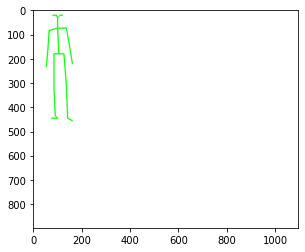

In [10]:
# 테스트 선 이미지 파일 확인

testfile="C:\\Users\\flors\\testfile.png"
testfile= cv2.imread(testfile)
plt.imshow(testfile)
print(testfile.shape)

In [11]:
# 테스트 선 이미지 파일 크기 조정

testfile= cv2.resize(testfile.astype('float32'), dsize=(150, 150))

In [12]:
# 선 이미지 파일 shape 조정

# testfile= np.expand_dims(testfile, axis=-1)
print(testfile.shape)
testfile = testfile.reshape(-1,150,150,3).astype('float32')/255
print(testfile.shape)

(150, 150, 3)
(1, 150, 150, 3)


In [13]:
# 결과 확인

test_predict=list()
test_predict.append(model.predict(testfile))

print('자세 상태의 각 확률은 ', model.predict(testfile))

if test_predict[0].argmax() == 1:  # argmax 확률 높은 거 뽑아냄
    text = '바른 자세'
    
elif test_predict[0].argmax() == 0:
    text = '골반 틀어짐'
    
elif test_predict[0].argmax() == 2:
    text = '오다리'

elif test_predict[0].argmax() == 3:
    text = '어깨 틀어짐'
    
print('자세 상태는 ', text, '입니다.') 

자세 상태의 각 확률은  [[0.15203243 0.33363208 0.45040387 0.06393165]]
자세 상태는  오다리 입니다.


#전체 이미지에 비해서 부위가 차지하는 부분은 적어 정확도가 떨어짐 

#정확도를 높이기 위해서 각각의 부위별로 세분화하여 측정하고자 함